Proyecto Final de Trading

Iteso 

Arturo Ruiz if702462

Juan Carlos Gonzalez if685009

In [9]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
import datetime

In [10]:
def get_prices(date):
    A1_OA_Da = 16                     # Day Align
    A1_OA_Ta = "America/Mexico_City"  # Time Align
    A1_OA_At = "practice"             # Tipo de cuenta
    A1_OA_In = "USD_MXN"              # Instrumento
    A1_OA_Gn = "M5"                   # Granularidad de velas
    A1_OA_Ak = "ee37e0cfccd3a6d2f842f120aaab81a4-3d14f03cc84eb3fd3fcb14ec3f999fec"
    ##obtener el spot
    a=datetime.datetime.strptime(date,"%m/%d/%Y %H:%M")
    today = a
    DD = datetime.timedelta(minutes=55)
    earlier = today - DD
    later = today + DD
    F1=later.strftime("%Y-%m-%dT%H:%M:%SZ")
    F2=earlier.strftime("%Y-%m-%dT%H:%M:%SZ")
    api = API(access_token=A1_OA_Ak)
    params = {"granularity": A1_OA_Gn, "price": "M", "dailyAlignment": A1_OA_Da,
              "alignmentTimezone": A1_OA_Ta, "from": F2, "to": F1}
    A1_Req1 = instruments.InstrumentsCandles(instrument=A1_OA_In, params=params)
    A1_Hist = api.request(A1_Req1)
    a=list(map(lambda i:[A1_Hist['candles'][i]['time'],float(A1_Hist['candles'][i]['mid']['o']),float(A1_Hist['candles'][i]['mid']['h']),
                          float(A1_Hist['candles'][i]['mid']['l']),float(A1_Hist['candles'][i]['mid']['c'])],range(len(A1_Hist['candles']))))
    pd_hist = pd.DataFrame(a,columns=['TimeStamp','Open','High','Low','Close'])
    pd_hist = pd_hist[['TimeStamp', 'Open', 'High', 'Low', 'Close']]
    pd_hist['TimeStamp'] = pd.to_datetime(pd_hist['TimeStamp'])
    
    return pd_hist 

In [11]:
data=pd.read_csv('data.csv')

In [12]:
a=data.loc[[a and b for a,b in zip(data.Actual>=data.Consensus,data.Consensus>=data.Previous)]]
b=data.loc[[a and b for a,b in zip(data.Actual>=data.Consensus,data.Consensus<data.Previous)]]
c=data.loc[[a and b for a,b in zip(data.Actual<data.Consensus,data.Consensus>=data.Previous)]]
d=data.loc[[a and b for a,b in zip(data.Actual<=data.Consensus,data.Consensus<data.Previous)]]
data['a']=[a and b for a,b in zip(data.Actual>=data.Consensus,data.Consensus>=data.Previous)]
data['b']=[a and b for a,b in zip(data.Actual>=data.Consensus,data.Consensus<data.Previous)]
data['c']=[a and b for a,b in zip(data.Actual<data.Consensus,data.Consensus>=data.Previous)]
data['d']=[a and b for a,b in zip(data.Actual<=data.Consensus,data.Consensus<data.Previous)]


In [13]:
# direcciones de los movimientos

In [14]:
week_days=list(map(lambda x:datetime.datetime.weekday(datetime.datetime.strptime(data.DateTime[x],"%m/%d/%Y %H:%M")),range(len(data))))

In [15]:
temp=list(map(lambda x:get_prices(data.DateTime[x]),range(len(data))))

In [16]:
c1_direction=list(map(lambda x:temp[x].loc[21].Close-temp[x].loc[11].Open,range(len(temp))))

In [17]:
c2_vol=list(map(lambda x:max(temp[x].High)-min(temp[x].Low),range(len(temp))))

In [18]:
c3_drawDown=list(map(lambda x:temp[x].loc[0].Open-temp[x].loc[21].Low,range(len(temp))))

In [19]:
c4_drawUp=list(map(lambda x:temp[x].loc[0].Open-temp[x].loc[21].High,range(len(temp))))

In [20]:
#driecciones

In [21]:
data['c1_direction']=c1_direction
data['c2_vol']=c2_vol
data['c3_drawDown']=c3_drawDown
data['c4_drawUp']=c4_drawUp


In [22]:
#frecuancia de cada escenario

In [23]:
po=[sum(data['a'])/len(data),
sum(data['b'])/len(data),
sum(data['c'])/len(data),
sum(data['d'])/len(data)]


In [24]:
tp=np.array([sum(data.loc[a.index]['c1_direction']>0)/sum(data['a']),
sum(data.loc[b.index]['c1_direction']>0)/sum(data['b']),
sum(data.loc[c.index]['c1_direction']>0)/sum(data['c']),
sum(data.loc[d.index]['c1_direction']>0)/sum(data['d'])])

In [25]:
tn=1-tp

In [26]:
#los 4 escenarios finales
results=np.transpose(pd.DataFrame([tp,tn,po],columns=['a','b','c','d'],index=['direccion positiva','direccion negativa','porcentaje ocurrencia']))

In [27]:
results

,direccion positiva,direccion negativa,porcentaje ocurrencia
a,0.428571,0.571429,0.205882
b,0.000000,1.000000,0.029412
c,0.450000,0.550000,0.588235
d,0.500000,0.500000,0.176471


Los parámetros a optimizar son: take profit, stop loss, la ventana de tiempo para hacer la compra, la cantidad de títulos más optima es realizar la compra y venta con el total de titulos posibles, y el numero de eventos que se utilizaran a c  d, o solamente 1 o 2 o 3.

In [28]:
# En esta parte del código se tiene todos los parámetros para llamar a optimizar más adelante dentro de una función.
def trading(x):
    stop_loss,take_profit,momento_compra,n_eventos=int(x[0]),int(x[1]),int(x[2]),int(x[3])
    total=10000 
    trade=[]
    # En este for recorre todos los eventos y checa en que estado estan a,b,c o d.
    for i in range(len(temp)):
        if (results.loc[data.iloc[i,7:11]]['direccion positiva']<=n_eventos)[0] and (results.loc[data.iloc[i,7:11]]['direccion positiva']>0)[0]:
#Aqui se especifica el monto en dólares para comprar cierto numero de títulos
            dolares_totales=np.trunc(total/temp[i].loc[0].Open)
            monto_compra=dolares_totales*temp[i].loc[momento_compra].Open
            total-=monto_compra

            if True in list(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)<-stop_loss/10000):
                stop_loss_position=np.where(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)<-stop_loss/10000)[0][0]+momento_compra+1
                stop_loss_profit=dolares_totales*temp[i].loc[stop_loss_position].Close
            else:
                stop_loss_position=None
            if True in list(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)>take_profit/10000):
                take_profit_position=np.where(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)>take_profit/10000)[0][0]+momento_compra+1
                take_profit_profit=dolares_totales*temp[i].loc[take_profit_position].Close
            else:
                take_profit_position=None

# En esta parte se evalua la parte de arriba, si sucedió el stop loss o take profit y en cual de los 4 casos posibles es el que sucedió.
        

            if not stop_loss_position==None and take_profit_position==None:
                monto_venta=stop_loss_profit
            elif not take_profit_position==None and stop_loss_position==None:
                monto_venta=take_profit_profit
            elif not take_profit_position==None and not stop_loss_position==None:
                if take_profit_position<stop_loss_position:
                    monto_venta=take_profit_profit
                else:
                    monto_venta=stop_loss_profit
            else:
                monto_venta=dolares_totales*temp[i].loc[21].Close


            pL=monto_venta-monto_compra
            total+=monto_venta
            trade.append([dolares_totales,pL,total])

        else:
            trade.append([0,0,total])
            # esto nos devuelve una lista de como se realizaron todos los trades de la cuenta y el balance final de esta
    
    trades=pd.DataFrame(trade,columns=['total quantity','P&L','Total'])
    return -trades.iloc[-1]['Total']
# la función te regresa el total de lo que se generó en la cuenta ya con los parámetros seleccionados.

In [31]:
# en esta parte comienza la optimización de los parámetros, pero al usar esta libreria no se puede guardar el histórico de como encuantra la solución, por eso abajo usamos el PSO.
#import scipy
#from scipy.optimize import Bounds
#from scipy.optimize import minimize
#
#x0=np.array([1.0,1.0,11.0,1.0])
#bounds = Bounds([0.0,0.0,1.0,0.0], [1000.0,1000.0,20.0,1.0])
#res=minimize(trading,x0,method='nelder-mead',options={'xtol': 1e-8, 'disp': True})
#te devuelve un resultado óptimo

In [32]:

# Este es el código del PSO en el cual se recupera información, guarda el óptimo y el historial
from __future__ import division
import random
import math
class Particle:
    def __init__(self,x0):
        self.position_i=[]          # posición de la particula
        self.velocity_i=[]          # su velocidad
        self.pos_best_i=[]          # mejor posición individual
        self.err_best_i=-1          # mejor error individual
        self.err_i=-1               # error individual

        for i in range(0,num_dimensions):
            self.velocity_i.append(random.uniform(-1,1))
            self.position_i.append(x0[i])

    # evalua el entrenamiento
    def evaluate(self,costFunc):
        self.err_i=costFunc(self.position_i)

        # revisa si la situación actual es una posicion individual mejor
        if self.err_i < self.err_best_i or self.err_best_i==-1:
            self.pos_best_i=self.position_i
            self.err_best_i=self.err_i

    # actualiza la velocidad de la particula
    def update_velocity(self,pos_best_g):
        w=0.5       # peso, la inercia de la particula
        c1=10        # peso a que tan rapido se mueve la particula
        c2=20       

        for i in range(0,num_dimensions):
            r1=random.random()
            r2=random.random()

            vel_cognitive=c1*r1*(self.pos_best_i[i]-self.position_i[i])
            vel_social=c2*r2*(pos_best_g[i]-self.position_i[i])
            self.velocity_i[i]=w*self.velocity_i[i]+vel_cognitive+vel_social

    # actualiza la nueva posición de las particulas
    def update_position(self,bounds):
        for i in range(0,num_dimensions):
            self.position_i[i]=self.position_i[i]+self.velocity_i[i]

            # ajusta a la máxima posición si es necesario
            if self.position_i[i]>bounds[i][1]:
                self.position_i[i]=bounds[i][1]

            # ajusta a la mínima posición si se necesita
            if self.position_i[i] < bounds[i][0]:
                self.position_i[i]=bounds[i][0]
                
class PSO():
    def __init__(self,costFunc,x0,bounds,num_particles,maxiter):
        global num_dimensions
        self.dataframe=list(np.zeros(maxiter))
        self.evaluations=list(np.zeros(maxiter))

        num_dimensions=len(x0)
        err_best_g=-1                   # mejor error del grupo
        pos_best_g=[]                   # mejor posición del grupo

        # se establece el enjambre
        swarm=[]
        for i in range(0,num_particles):
            swarm.append(Particle(x0))

        # comienza el ciclo de optimización
        i=0
        while i < maxiter:
            
            # ciclo y aprendisaje de las particulas
            for j in range(0,num_particles):
                swarm[j].evaluate(costFunc)

                # determina si la particula actual es la mejor globalmente
                if swarm[j].err_i < err_best_g or err_best_g == -1:
                    pos_best_g=list(swarm[j].position_i)
                    err_best_g=float(swarm[j].err_i)

            # actualiza las velocidades y posiciones del enjambre

            list(map(lambda j:swarm[j].update_velocity(pos_best_g),range(num_particles)))
            list(map(lambda j:swarm[j].update_position(bounds),range(num_particles)))
            self.dataframe[i]=pd.DataFrame(list(map(lambda x:x.position_i,swarm)))
            self.evaluations[i]=pd.DataFrame(list(map(lambda x:x.err_best_i,swarm)))
            i+=1
            print(i)
        
        # imprime resultados
        print('FINAL:')
        self.values=[list(map(lambda x:int(x),pos_best_g)),err_best_g,swarm]
    def values(self):
        return self.values

In [33]:
#las condiciones
x0=np.array([1.0,1.0,11.0,1.0])
bounds=[(1,1000),(1,1000),(1,20),(0,1)]
res=PSO(trading,x0,bounds,num_particles=10,maxiter=30)
#lo almacena los valores en res

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
FINAL:


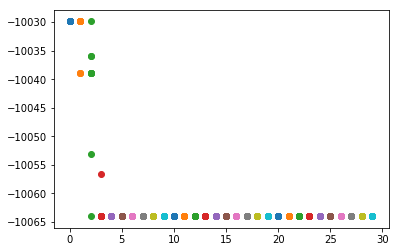

In [34]:
# son las iteraciones y no llega a una convergencia porque usamos pocas iteraciones para que no tardara demasiado en correr.
list(map(lambda x,y:plt.scatter(np.ones(len(x))*y,x),res.evaluations,range(len(res.evaluations))))

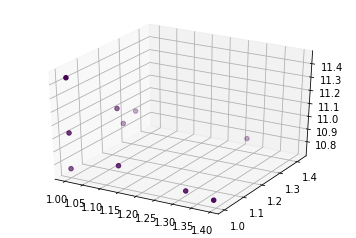

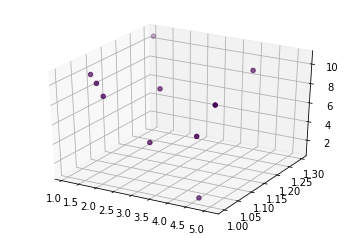

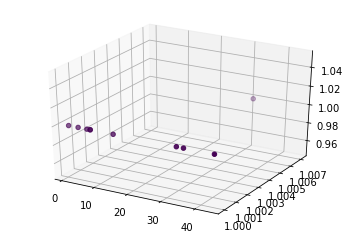

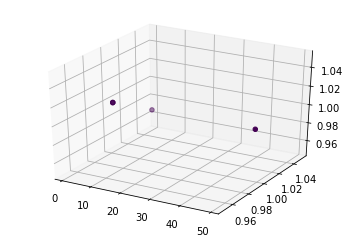

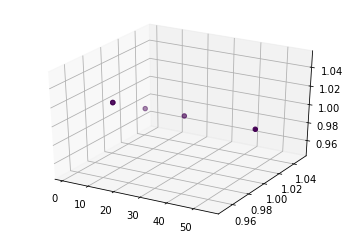

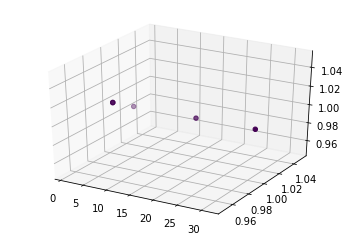

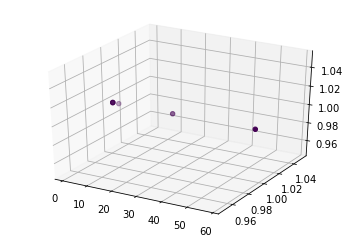

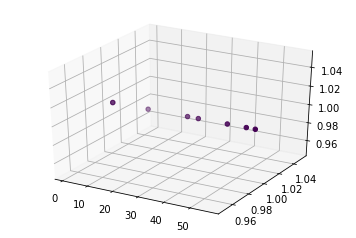

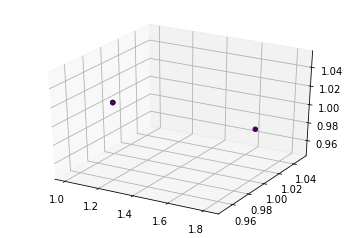

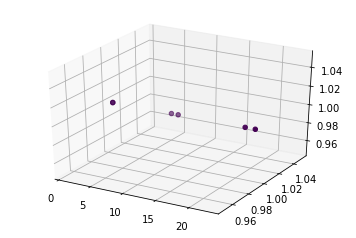

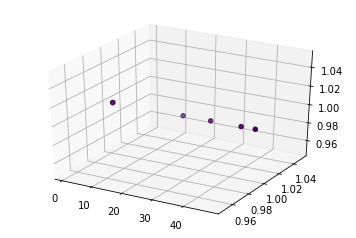

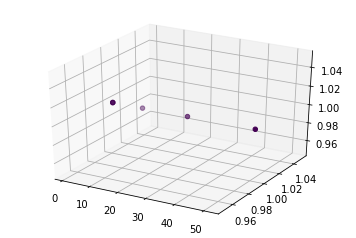

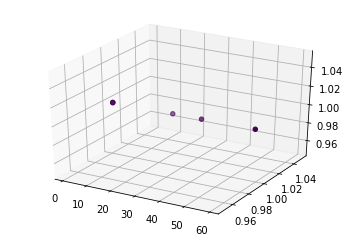

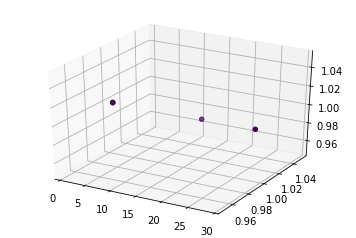

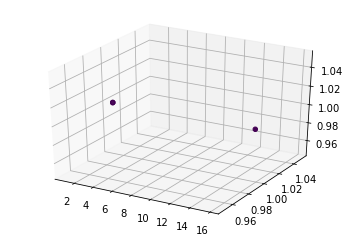

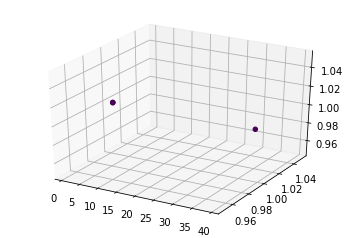

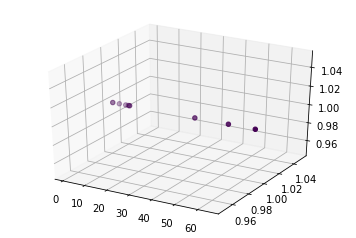

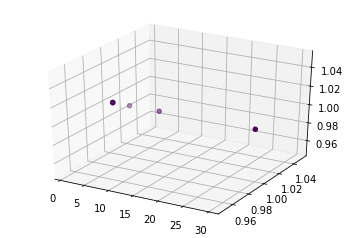

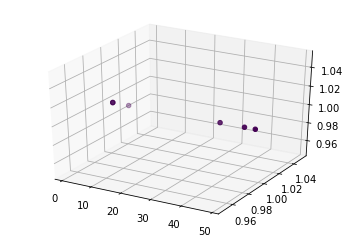

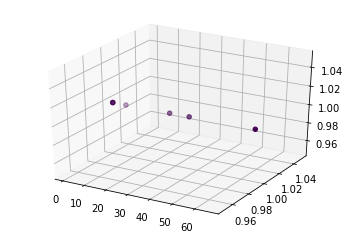

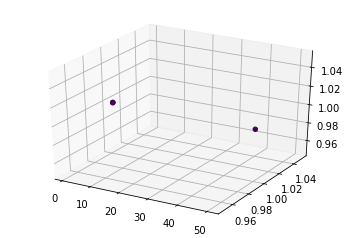

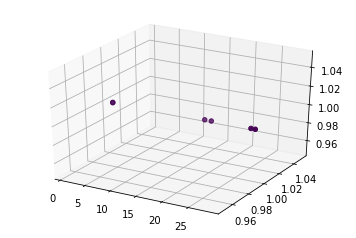

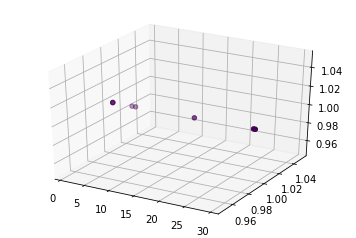

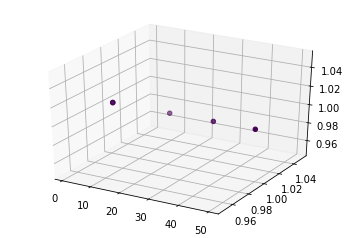

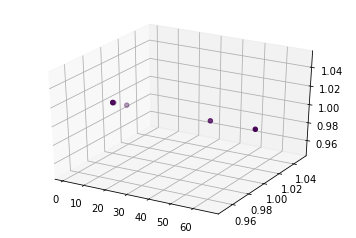

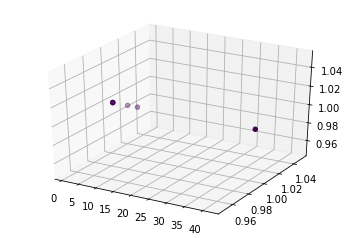

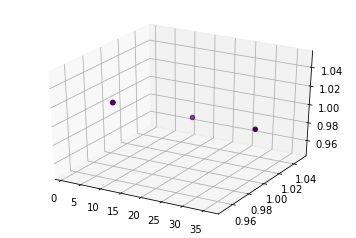

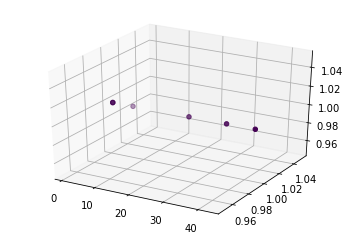

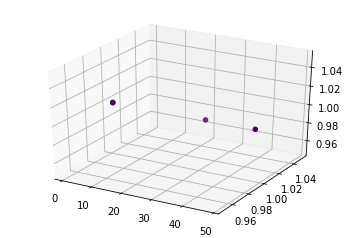

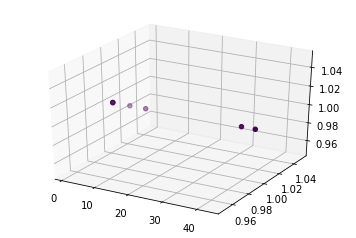

In [35]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
# Creamos la figura


# Agrrgamos un plano 3D y la 4ta variable es la intensidad del color
for i in range(len(res.dataframe)):
    fig = plt.figure()
    ax1 = fig.add_subplot(111,projection='3d')
    ax1.scatter(res.dataframe[i][0], res.dataframe[i][1], res.dataframe[i][2], c=res.dataframe[i][3].apply(lambda x:.5 if x>=.5 else .45 if x>=.45 else .42), marker='o')
    plt.show()


In [36]:
# esta función es igual a la anterioir pero al final en lugar de regresarte el ultimo resultado de regresa todo el histórico de los trades.
def trading(x):
    stop_loss,take_profit,momento_compra,n_eventos=int(x[0]),int(x[1]),int(x[2]),int(x[3])
    total=10000 
    trade=[]
    for i in range(len(temp)):
        if (results.loc[data.iloc[i,7:11]]['direccion positiva']<=n_eventos)[0] and (results.loc[data.iloc[i,7:11]]['direccion positiva']>0)[0]:

            dolares_totales=np.trunc(total/temp[i].loc[0].Open)
            monto_compra=dolares_totales*temp[i].loc[momento_compra].Open
            total-=monto_compra

            if True in list(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)<-stop_loss/10000):
                stop_loss_position=np.where(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)<-stop_loss/10000)[0][0]+momento_compra+1
                stop_loss_profit=dolares_totales*temp[i].loc[stop_loss_position].Close
            else:
                stop_loss_position=None
            if True in list(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)>take_profit/10000):
                take_profit_position=np.where(np.array(temp[i].iloc[momento_compra+1:,-1])-np.array(temp[i].loc[momento_compra].Open)>take_profit/10000)[0][0]+momento_compra+1
                take_profit_profit=dolares_totales*temp[i].loc[take_profit_position].Close
            else:
                take_profit_position=None



            if not stop_loss_position==None and take_profit_position==None:
                monto_venta=stop_loss_profit
            elif not take_profit_position==None and stop_loss_position==None:
                monto_venta=take_profit_profit
            elif not take_profit_position==None and not stop_loss_position==None:
                if take_profit_position<stop_loss_position:
                    monto_venta=take_profit_profit
                else:
                    monto_venta=stop_loss_profit
            else:
                monto_venta=dolares_totales*temp[i].loc[21].Close


            pL=monto_venta-monto_compra
            total+=monto_venta
            trade.append([dolares_totales,pL,total])

        else:
            trade.append([0,0,total])
    
    trades=pd.DataFrame(trade,columns=['total quantity','P&L','Total'])
    return trades#.iloc[-1]['Total']
#con esto te regresa todos.

In [37]:
trades=trading(res.values[0])

In [38]:
precios_compras=(-trades['P&L']+trades['Total'])/trades['total quantity']

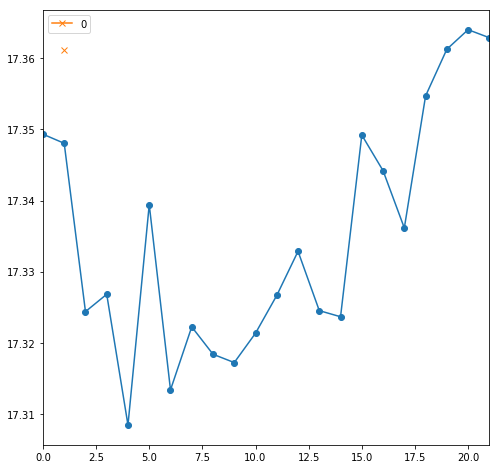

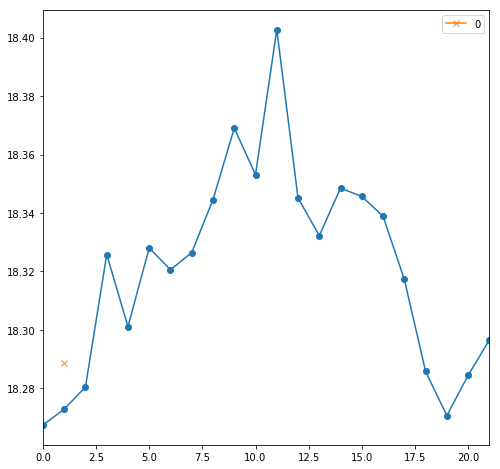

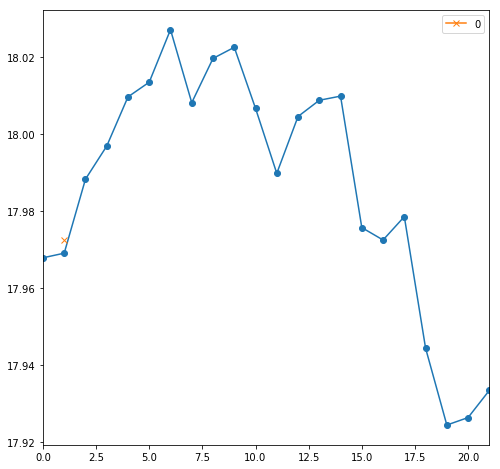

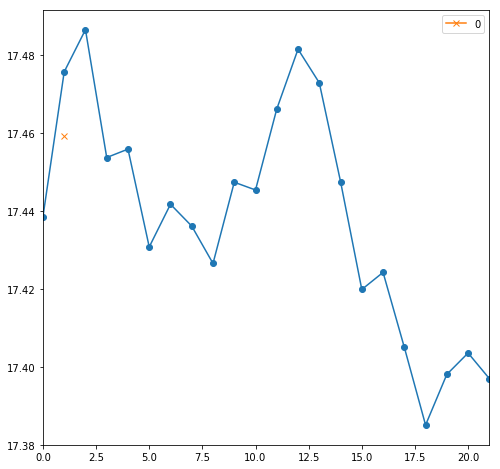

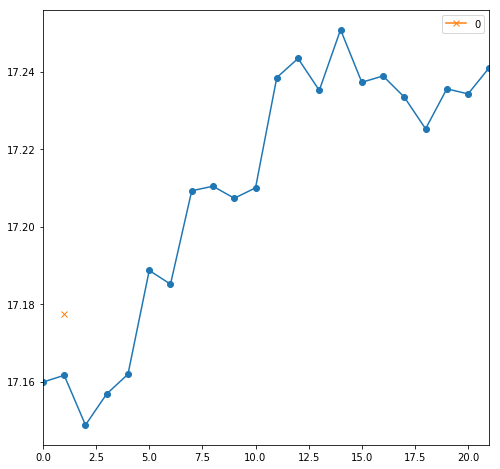

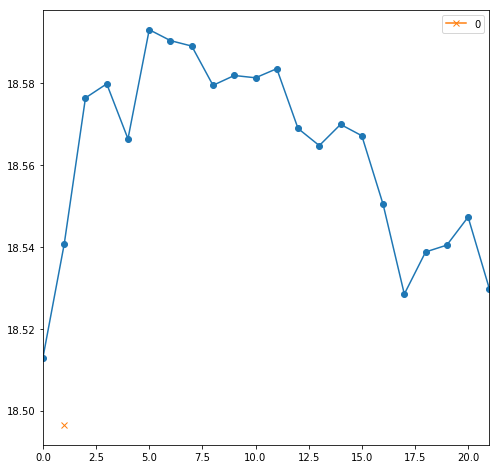

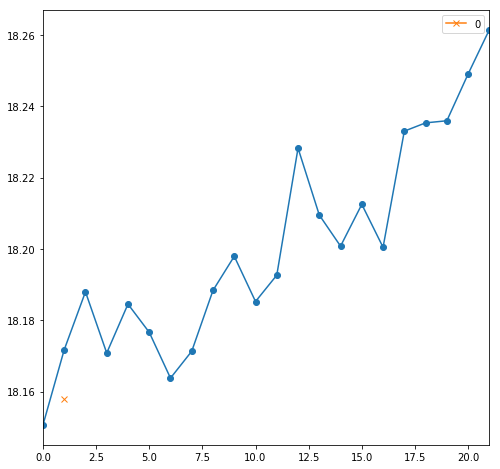

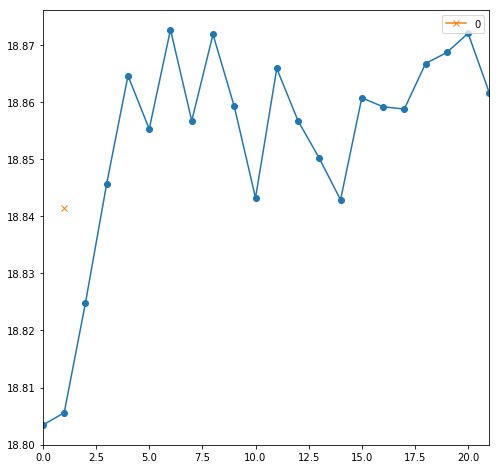

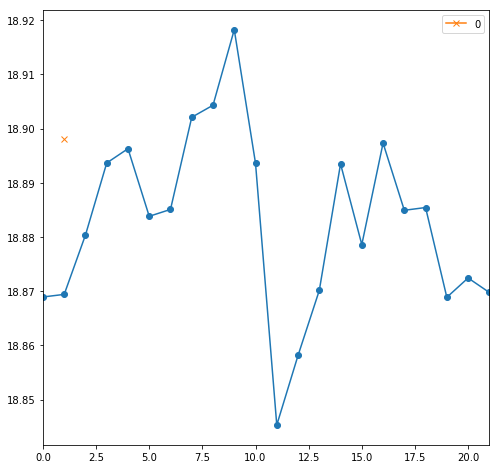

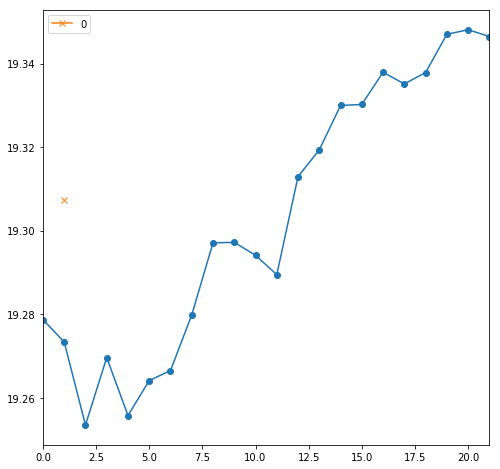

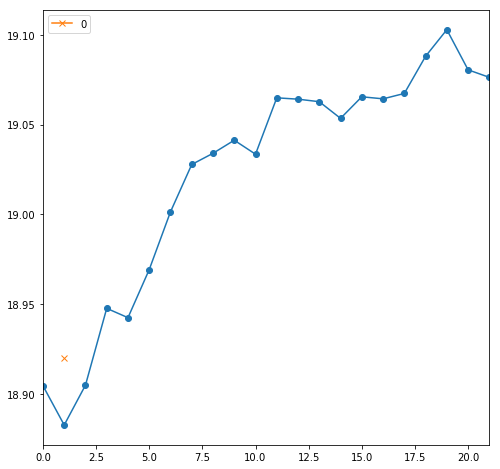

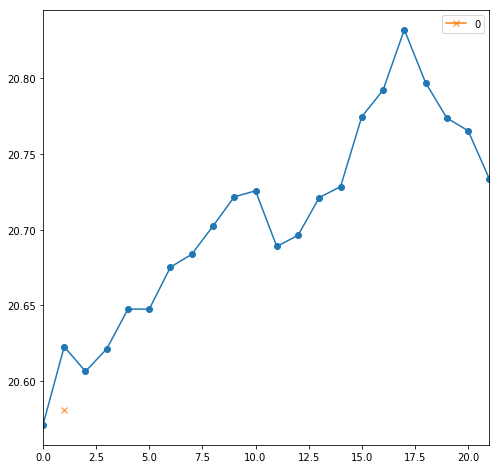

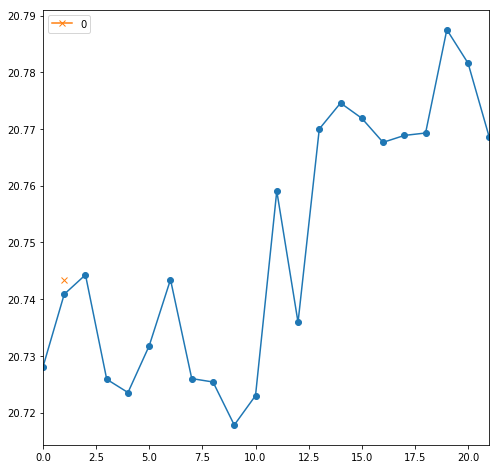

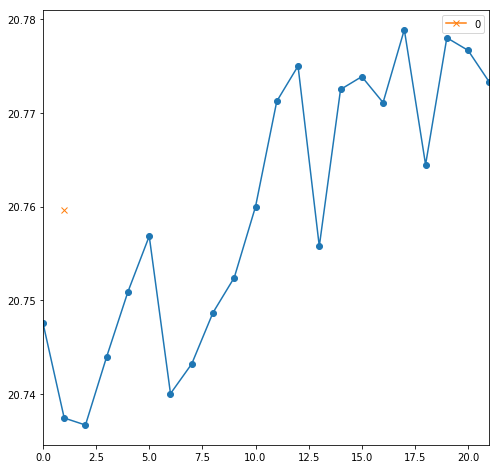

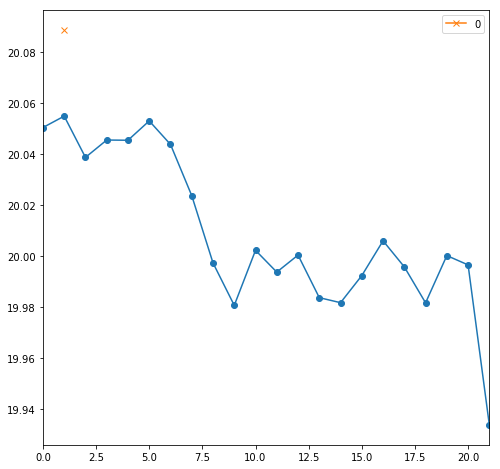

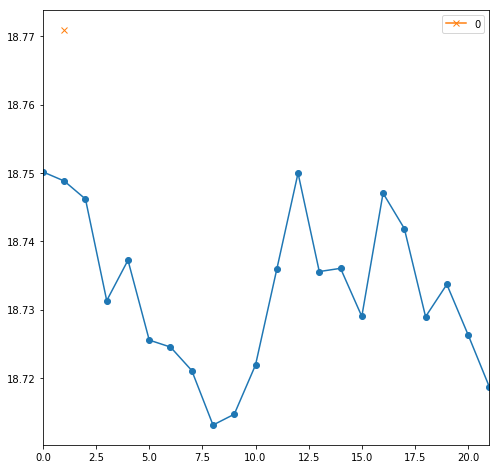

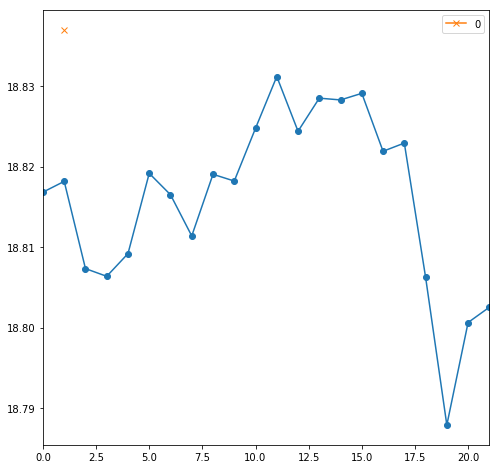

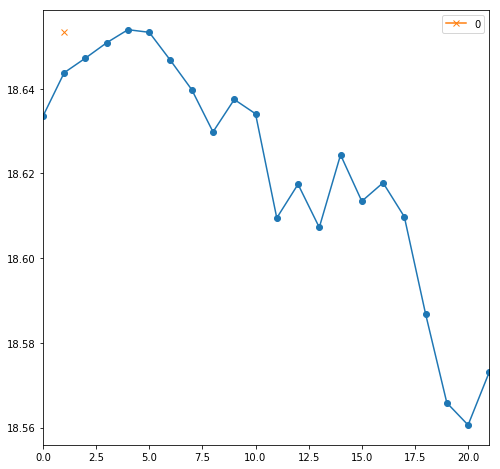

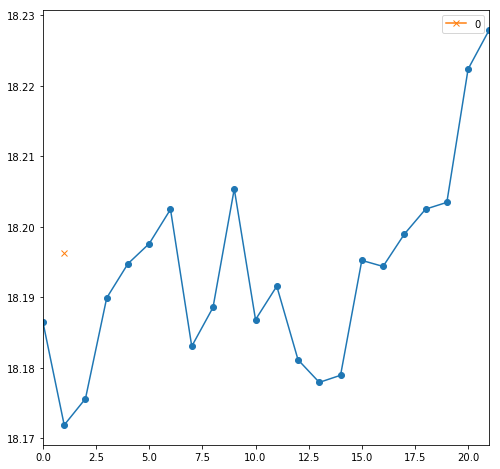

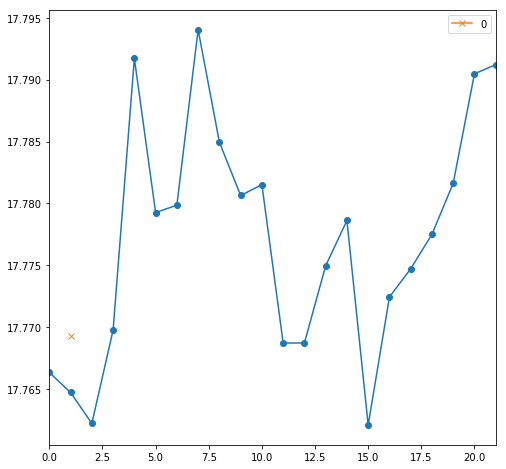

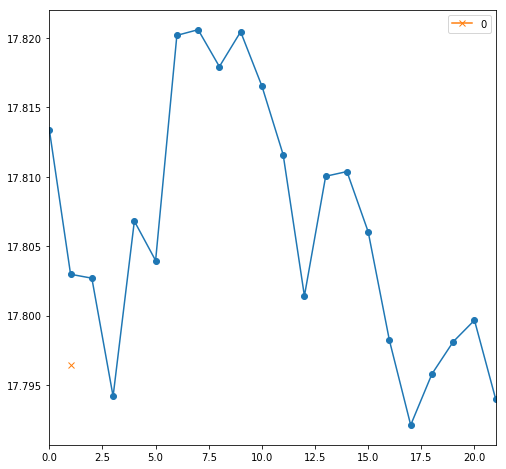

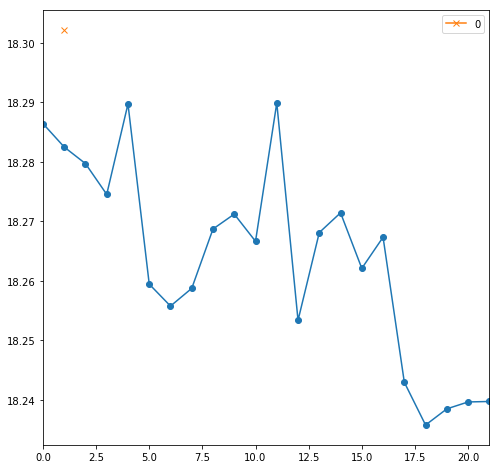

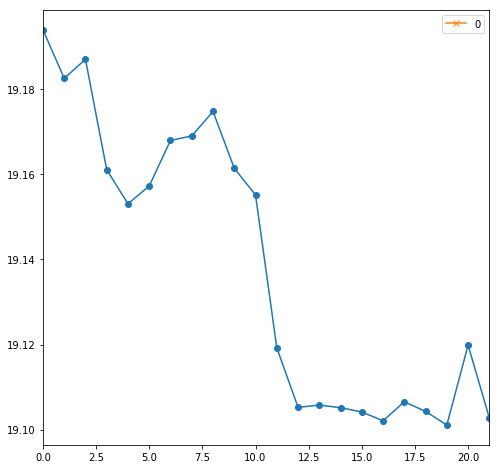

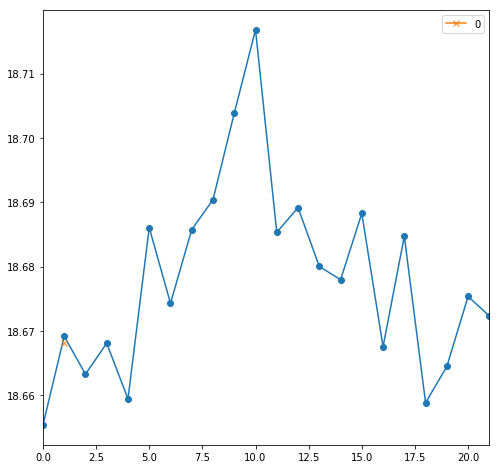

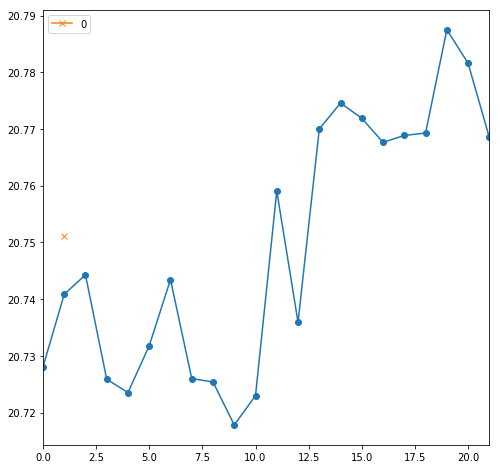

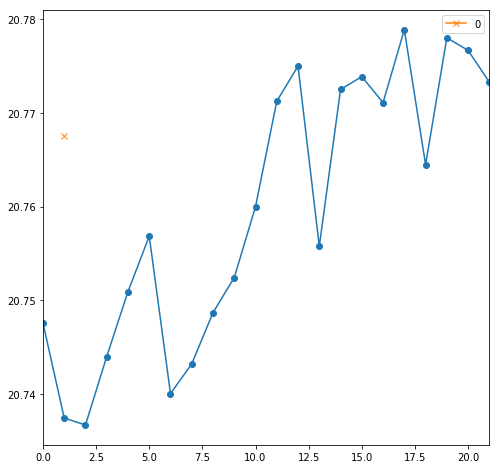

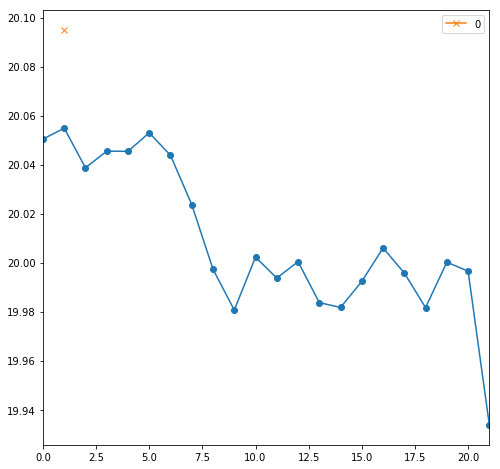

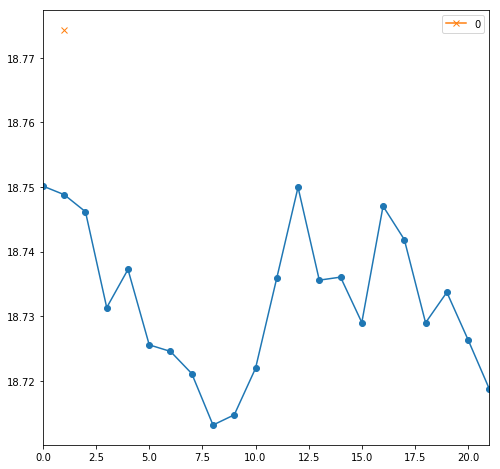

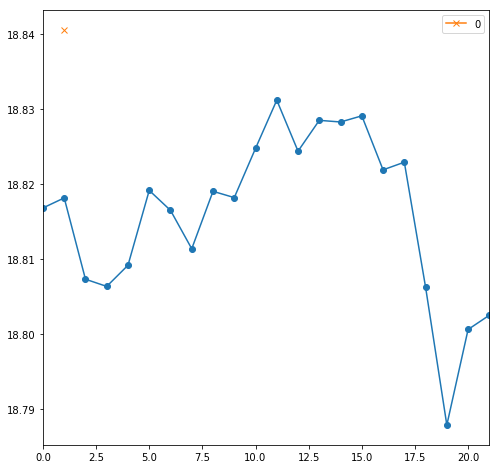

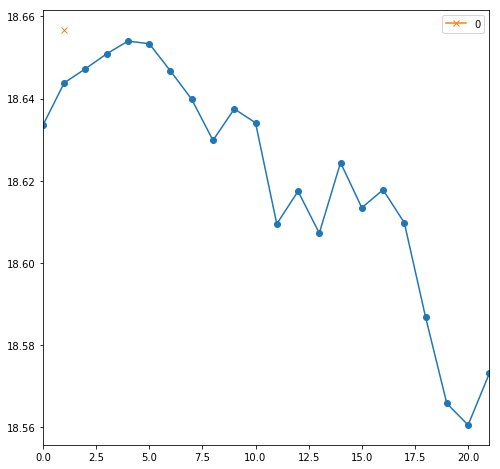

In [39]:
#La gráfica de lo históricos y donde se realizaron las compras representados por una x.

for i in range(len(res.dataframe)):
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    temp[i]['Close'].plot(marker='o',x=ax)
    pd.DataFrame([precios_compras[i]],index=[res.values[0][2]]).plot(marker='x',ax=ax)
    plt.show()


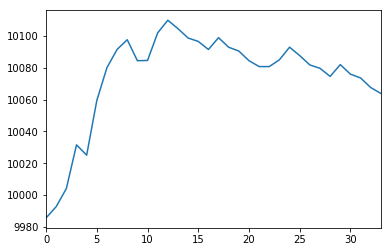

In [40]:
#Gráfica para visualizar el capital de la cuenta
trades.Total.plot()

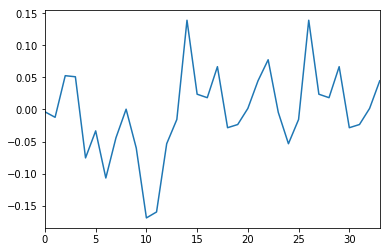

In [41]:
#Gráfica con el drowdown de la cuenta
data.c3_drawDown.plot()

Se calculan las medidas de atribución al desempeño básicas

In [42]:
#Rendimiento final
trades.Total.iloc[-1]/10000-1

0.0063917119999994387

In [43]:
#desviación estandar de rend diarios
np.std(((np.array(trades.Total.iloc[:-1])-np.array(trades.Total.iloc[1:]))/np.array(trades.Total.iloc[1:])))

0.0010471426052523726

Se calculan las medidas de atribución al desempeño para trading

In [44]:
#min maximo y mediana
data.c3_drawDown.min(),data.c3_drawDown.max(),data.c3_drawDown.mean()

(-0.16907999999999745, 0.13909999999999911, -0.004150000000000359)

La cuenta si termina con un rendimiento final positivo

In [45]:
#se calcula el ratio de drawdown vs ganancia y si es menor a 1.
data.c3_drawDown.min()/(trades.Total.iloc[-1])

-1.6800615305543924e-05

El tiempo real no lo alcanzaremos a terminar.